In [26]:
# Core
import numpy as np
import cv2
import io
from skimage.measure import label, regionprops

# Visualization
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# File Chooser
import tkinter as tk
from tkinter import filedialog

In [6]:
# Settings & Globals
printText = False

kernel = np.ones((3, 3), np.uint8)

In [7]:
# Get Image
def getImage(file_path="", blockSize=505, C=-2):
    root = tk.Tk()
    root.withdraw()
    if file_path == "":
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", ".png .jpg")])
    src_img = cv2.imread(file_path)
    copy = src_img.copy()
    copy[:, :, 1] = copy[:, :, 2] = 0
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    gray = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C
    )  ########## 2 magic numbers here
    return gray

In [8]:
# Noise Removal
def noiseRemoval(gray, openIter=3, closeIter=3):
    clean = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=openIter)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=closeIter)
    return clean

In [9]:
# Get Coverage
def getCoverage(clean):
    coverage = np.count_nonzero(clean) / (clean.shape[0] * clean.shape[1])
    if printText:
        print(str(coverage) + "%")
    return coverage

In [10]:
# copied from JUN_NETWORKS at https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [22]:
# Get Regions
def getRegions(sourceImage,clean, blockSize=403, C=-4, minArea=0.00025, boxColor="red"):
    sure_bg = cv2.dilate(clean, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 0)
    dist_transform = np.uint8(dist_transform)
    dt_fg = cv2.adaptiveThreshold(
        dist_transform, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 403, -4
    )
    unknown = cv2.subtract(sure_bg, dt_fg)
    ret, markers = cv2.connectedComponents(dt_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    shedded = cv2.watershed(sourceImage, markers)
    edge = markers == -1
    edge = cv2.dilate(edge.astype(np.uint8), kernel)

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(sourceImage)

    label_image = label(markers)
    region_count = 0
    height = label_image.shape[1]
    width = label_image.shape[0]
    for region in regionprops(label_image):
        if region.area >= (minArea * height * width):  # Aribtuary
            region_count += 1
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle(
                (minc, minr),
                maxc - minc,
                maxr - minr,
                fill=False,
                edgecolor=boxColor,
                linewidth=1,
            )
            ax.add_patch(rect)

    regionsFound=get_img_from_fig(plt)
#     plt.savefig("regionsFound.png")
#     regionsFound = cv2.imread("regionsFound.png")
#     regionsFound = cv2.cvtColor(regionsFound, cv2.COLOR_BGR2RGB)

    if printText:
        print(region_count)

    return region_count, regionsFound

In [27]:
def processImage(
    file_path="",
    blockSize1=505,
    C1=-2,
    blockSize2=403,
    openIter=3,
    closeIter=3,
    C2=-4,
    minArea=0.00025,
    boxColor="red",
):
    sourceImage = cv2.imread(file_path)
    sourceImage = cv2.cvtColor(sourceImage, cv2.COLOR_BGR2RGB)
    gray = getImage(file_path, blockSize1, C1)
    clean = noiseRemoval(gray, openIter, closeIter)
    coverage = getCoverage(clean)
    regionCount, regionsFound = getRegions(
        sourceImage, clean, blockSize2, C2, minArea, boxColor
    )
    return coverage, regionCount, regionsFound

In [28]:
def _init_():
    return

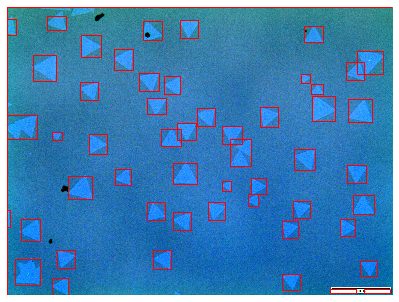

In [30]:
a, b, c = processImage("testingImage.jpg")